# Import dependencies

In [3]:
import sys
sys.path.append('/input/Mask_RCNN')

In [1]:
import os
import sys
import random
import math
import re
import time
import cv2
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import csv
import imageio
import skimage
from config import Config
from skimage.morphology import label
from skimage.feature import canny
from skimage import exposure
from keras.callbacks import Callback
from skimage.morphology import binary_closing, binary_opening, disk, binary_dilation
from scipy.ndimage.morphology import binary_fill_holes
from sklearn.externals import joblib
from skimage.transform import PiecewiseAffineTransform, warp
from skimage.morphology import watershed
from skimage.filters import sobel
from imp import reload
import utils
import model_raw_Taugment as modellib
import visualize
from model_raw_Taugment import log

#from deepsense import neptune
#ctx = neptune.Context()

/home/zumeng/anaconda2/envs/py3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/zumeng/anaconda2/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# tf.set_random_seed(127)

Let's download the mask_rcnn trained on COCO dataset to initialize the model.

In [3]:
# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

We will now define the monitor that will help keep track on the training process.
With this you will be able to see your charts in the `charts` tab

In [4]:
class LossHistory(Callback):  
    def on_train_begin(self, logs={}):
        self.batch_id = 0
        self.epoch_id = 0

    def on_batch_end(self, batch, logs={}):
        self.batch_id += 1
        print('loss', self.batch_id, float(logs.get('loss')))
        print('rpn_class_loss', self.batch_id, float(logs.get('rpn_class_loss')))
        print('rpn_bbox_loss', self.batch_id, float(logs.get('rpn_bbox_loss')))
        print('mrcnn_class_loss', self.batch_id, float(logs.get('mrcnn_class_loss')))
        print('mrcnn_bbox_loss', self.batch_id, float(logs.get('mrcnn_bbox_loss')))
        print('mrcnn_mask_loss', self.batch_id, float(logs.get('mrcnn_mask_loss')))
    
    def on_epoch_end(self, batch, logs={}):
        self.epoch_id += 1
        print('val_loss', self.epoch_id, float(logs.get('val_loss')))
        print('val_rpn_class_loss', self.epoch_id, float(logs.get('val_rpn_class_loss')))
        print('val_rpn_bbox_loss', self.epoch_id, float(logs.get('val_rpn_bbox_loss')))
        print('val_mrcnn_class_loss', self.epoch_id, float(logs.get('val_mrcnn_class_loss')))
        print('val_mrcnn_bbox_loss', self.epoch_id, float(logs.get('val_mrcnn_bbox_loss')))
        print('val_mrcnn_mask_loss', self.epoch_id, float(logs.get('val_mrcnn_mask_loss')))

Now we will load the metadata and divide them in train and valid splits

In [5]:
def train_valid_split(meta, validation_size, valid_category_ids=None):
    meta_train = meta[meta['is_train'] == 1]
    meta_train_split, meta_valid_split = split_on_column(meta_train,
                                                         column='vgg_features_clusters',
                                                         test_size=validation_size,
                                                         random_state=1234,
                                                         valid_category_ids=valid_category_ids
                                                         )
    return meta_train_split, meta_valid_split


def split_on_column(meta, column, test_size, random_state=1, valid_category_ids=None):
    if valid_category_ids is None:
        categories = meta[column].unique()
        np.random.seed(random_state)
        valid_category_ids = np.random.choice(categories,
                                              int(test_size * len(categories)))
    valid = meta[meta[column].isin(valid_category_ids)].sample(frac=1, random_state=random_state)
    train = meta[~(meta[column].isin(valid_category_ids))].sample(frac=1, random_state=random_state)
    return train, valid

meta = pd.read_csv('./stage1_metadata.csv')

meta_ts = meta[meta['is_train']==0]
meta_train, meta_valid = train_valid_split( meta[meta['is_train']==1],0.2,[0])

# Mask-RCNN configuration
We will now define parameters for our mask-rcnn. 
Tweak them to get better results!

In [6]:
class DsbConfig(Config):

    # Give the configuration a recognizable name
    NAME = "all"
      
    LEARNING_RATE = 1e-2
    
    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution image
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask
    
    # Train on 1 GPU and 8 images per GPU. Batch size is GPUs * images/GPU.
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    # Total number of steps (batches of samples) to yield from generator before declaring one epoch finished and starting the next epoch.
    # typically be equal to the number of samples of your dataset divided by the batch size
    STEPS_PER_EPOCH = 300
    VALIDATION_STEPS = 40

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + nucleis
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    IMAGE_PADDING = True  # currently, the False option is not supported
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels, maybe add a 256?
    # The strides of each layer of the FPN Pyramid. These values
    # are based on a Resnet101 backbone.
    BACKBONE_STRIDES = [4, 8, 16, 32, 64]
    # How many anchors per image to use for RPN training
    RPN_TRAIN_ANCHORS_PER_IMAGE = 320 #300
    
    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 2000
    POST_NMS_ROIS_INFERENCE = 2000
    POOL_SIZE = 7
    MASK_POOL_SIZE = 14
    MASK_SHAPE = [28, 28]
    TRAIN_ROIS_PER_IMAGE = 500
    RPN_NMS_THRESHOLD = 0.7
    MAX_GT_INSTANCES = 256
    DETECTION_MAX_INSTANCES = 300 
    # Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.7 # may be smaller?
    # Non-maximum suppression threshold for detection
    DETECTION_NMS_THRESHOLD = 0.3 # 0.3
    
    #MEAN_PIXEL = np.array([56.02,54.02,54.26])
    MEAN_PIXEL = np.array([123.7,116.8,103.9])
    
    # Weight decay regularization
    WEIGHT_DECAY = 0.0001
    SCALES = [512]
    MAIN_SCALE = 0
    BACKBONE = "resnet50"
    GRADIENT_CLIP_NORM = 0.5
    
config = DsbConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_SHAPES                [[128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]
 [  8   8]]
BACKBONE_SHAPES_LIST           [array([[128, 128],
       [ 64,  64],
       [ 32,  32],
       [ 16,  16],
       [  8,   8]])]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        300
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             0.5
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  512
IMAGE_MIN_DIM                  512
IMAGE_PADDING                  True
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.01
MAIN_SCALE                     0
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               256
MEAN_PIXEL               

In [7]:
class InferenceConfig(DsbConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    # MEAN_PIXEL = np.array([56.02288505, 54.02376286, 54.26675248])
inference_config = InferenceConfig()

# Dataset definition

We need to define our datasets for the data science bowl competition

In [8]:
class DsbDataset(utils.Dataset):

    def load_dataset(self, ids, train_mode=True):
        self.add_class("dsb", 1, "nuclei")
        if train_mode:
            directory = dsb_dir
        else:
            directory = test_dir
        for i, id in enumerate(ids):
            image_dir = os.path.join(directory, id)
            self.add_image("dsb", image_id=i, path=image_dir)
            

    def load_image(self, image_id, non_zero=None):
        info = self.image_info[image_id]
        path = info['path']
        image_name = os.listdir(os.path.join(path, 'images'))
        image_path = os.path.join(path, 'images', image_name[0])
        image = imageio.imread(image_path)
        if image.shape[2] != 3:
            image = image[:,:,:3]
        #image = self.preprocess(image)
        image = image
        return image

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        path = info['path']
        mask_dir = os.path.join(path, 'masks')
        mask_names = os.listdir(mask_dir)
        count = len(mask_names)
        mask = []
        for i, el in enumerate(mask_names):
            msk_path = os.path.join(mask_dir, el)
            msk = imageio.imread(msk_path)
            if np.sum(msk) == 0:
                print('invalid mask')
                continue
            msk = msk.astype('float32')/255.
            if len(msk.shape) == 3:
                msk = msk[:,:,0]
            mask.append(msk)
        mask = np.asarray(mask)
        mask[mask > 0.] = 1.
        mask = np.transpose(mask, (1,2,0))
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        count = mask.shape[2]
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        class_ids = [self.class_names.index('nuclei') for s in range(count)]
        class_ids = np.asarray(class_ids)
        return mask, class_ids.astype(np.int32)
    
    def preprocess(self, img):
        gray = skimage.color.rgb2gray(img.astype('uint8'))
        img = skimage.color.gray2rgb(gray)
        img *= 255.
        return img

In [9]:
color_ids = [i.strip() for i in list(pd.read_csv("color.csv").color_id)]

# Training dataset
dataset_train = DsbDataset()
dataset_train.load_dataset(train_ids)
dataset_train.load_dataset(color_ids)
dataset_train.load_dataset(color_ids)

dataset_train.prepare()

# Validation dataset
dataset_val = DsbDataset()
dataset_val.load_dataset(train_ids)
dataset_val.prepare()

# Test dataset
dataset_test = DsbDataset()
dataset_test.load_dataset(test_ids, train_mode=False)
dataset_test.prepare()

In [10]:
dsb_dir = './stage1_train'
train_ids = os.listdir(dsb_dir)
test_dir = './stage1_test'
test_ids = os.listdir(test_dir)

In [11]:
total_ids = os.listdir('./stage1_train')
train_ids = list(meta_train.ImageId.values)
for tid in train_ids :
    if tid not in total_ids :
        train_ids.remove(tid)
val_ids = list(meta_valid.ImageId.values)
for tid in val_ids :
    if tid not in total_ids :
        train_ids.remove(tid)
dsb_dir = './stage1_train'
test_dir = './stage1_test'
test_ids = os.listdir(test_dir)

In [12]:
# Training dataset
dataset_train = DsbDataset()
dataset_train.load_dataset(train_ids)
#dataset_train.load_dataset(color_ids)
#dataset_train.load_dataset(color_ids)

dataset_train.prepare()

# Validation dataset
dataset_val = DsbDataset()
dataset_val.load_dataset(val_ids)
dataset_val.prepare()

# Test dataset
dataset_test = DsbDataset()
dataset_test.load_dataset(test_ids, train_mode=False)
dataset_test.prepare()

In [13]:
len(set(color_ids)&set(meta_valid.ImageId))

1

In [14]:
len(meta_valid.ImageId)

58

for i in range(670):
    masks,_ = dataset_train.load_mask(5)
    masks.shape

image_ids = np.random.choice(dataset_train.image_ids, 10)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names,limit = 2)

Let's take a look at some images

# Model Training

OK! 

I think we are ready to do some training!
We will instantiate the model and initialize it with COCO weights

In [27]:

reload(modellib)

<module 'model_raw_Taugment' from '/home/zumeng/DSB2018/dsb/model_raw_Taugment.py'>

In [28]:
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [29]:
init_with = "last" # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights("./resnet50_weights_tf_dim_ordering_tf_kernels.h5", by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

Let's train and investigate the learning curves for all the mask-rcnn losses in the `charts` and `channels`

In [30]:
model.train(dataset_train, dataset_train, 
                learning_rate=config.LEARNING_RATE/10,
                epochs=60, 
                layers="all",)
                #clbcks=[LossHistory()])
model.train(dataset_train, dataset_train, 
                learning_rate=config.LEARNING_RATE,
                epochs=60, 
                layers="all",)   


Starting at epoch 53. LR=0.001

Checkpoint Path: /home/zumeng/DSB2018/dsb/logs/all20180402T1605/mask_rcnn_all_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2

/home/zumeng/anaconda2/envs/py3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/zumeng/anaconda2/envs/py3/lib/python3.6/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 54/60
 68/300 [=====>........................] - ETA: 4:49 - loss: 0.6214 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.1825 - mrcnn_class_loss: 0.0916 - mrcnn_bbox_loss: 0.1289 - mrcnn_mask_loss: 0.2045

Process Process-3:
Process Process-2:
Traceback (most recent call last):
  File "/home/zumeng/anaconda2/envs/py3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/zumeng/anaconda2/envs/py3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/zumeng/anaconda2/envs/py3/lib/python3.6/site-packages/keras/utils/data_utils.py", line 677, in _data_generator_task
    generator_output = next(self._generator)
  File "/home/zumeng/DSB2018/dsb/model_raw_Taugment.py", line 1648, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/zumeng/DSB2018/dsb/model_raw_Taugment.py", line 1189, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "<ipython-input-8-4f9ee7e88cd1>", line 46, in load_mask
    msk = msk.astype('float32')/255.
KeyboardInterrupt
Traceback (most recent call last):
  File "/home/zumeng/anaconda2/envs/py3/lib/python3.6/multiprocessing/p

KeyboardInterrupt: 

In [ ]:
for i in range(11,30):
    dims = np.random.choice([256,320,384,448,512,576,640])

    class newconfig(DsbConfig):
        IMAGE_MIN_DIM = dims
        IMAGE_MAX_DIM = dims
    config = newconfig()
    model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)
    model.load_weights(model.find_last()[1], by_name=True)
    
    model.train(dataset_train, dataset_train, 
                learning_rate=config.LEARNING_RATE,
                epochs= i, 
                layers="heads",)

In [ ]:
model.train(dataset_train, dataset_train, 
                learning_rate=config.LEARNING_RATE/100,
                epochs=30, 
                layers="all")

# Evaluate
I think we are ready to see how our model does on the validation!

In [31]:
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/zumeng/DSB2018/dsb/logs/all20180402T1605/mask_rcnn_all_0052.h5


In [32]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

original_image           shape: (512, 512, 3)         min:    0.00000  max:  232.00000
image_meta               shape: (10,)                 min:    0.00000  max:  696.00000
gt_class_id              shape: (12,)                 min:    1.00000  max:    1.00000
gt_bbox                  shape: (12, 4)               min:    7.00000  max:  442.00000
gt_mask                  shape: (512, 512, 12)        min:    0.00000  max:    1.00000
total nuclei count:  12


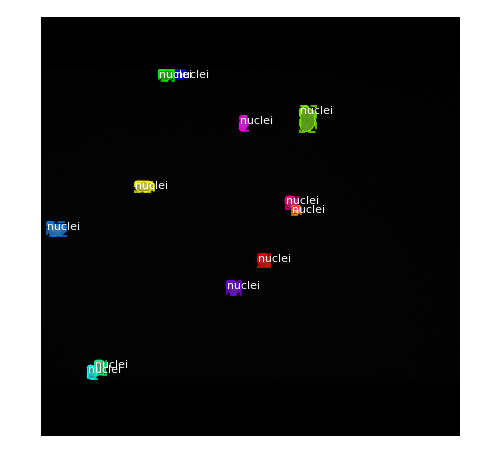

In [33]:
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False,augment=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

print("total nuclei count: ",gt_bbox.shape[0])
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_val.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  232.00000
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  128.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  512.00000
total nuclei detected:  12


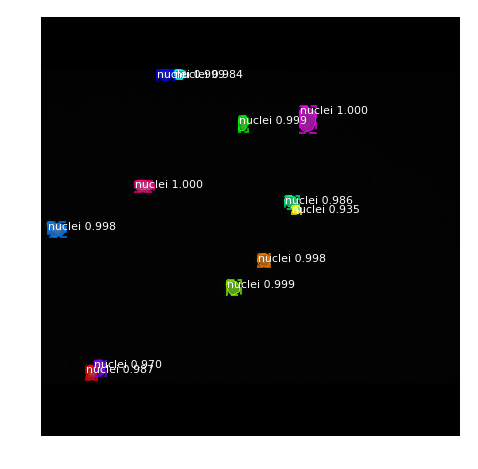

In [34]:
results = model.detect([original_image], verbose=1)

r = results[0]

print("total nuclei detected: ",r['masks'].shape[2])
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [ ]:
r['masks'].shape

In [ ]:
import transform
reload(transform)
original_image = dataset_train.load_image(278)

In [ ]:
image = transform.random_hue_transform(original_image,limit=[-0.05,0.05],u=0)
image = transform.random_brightness_transform(image,limit=[0.3,1.3],u=1)
image = transform.random_contrast_transform(image,limit=[0.7,1.3],u=0)
image = transform.ran
dom_saturation_transform(image,limit=[0.7,1.3],u=0)
image = transform.random_noise_transform(image,limit=[0, 0.02],u=0)

In [ ]:
np.set_printoptions(threshold = 10 ,edgeitems = 10)


In [ ]:
results

# Create Submission
It is looking good on the validation.
Let's see how will it do on the public LB.

In [19]:
raw_predictions = []
for test_id in dataset_test.image_ids:
    test_image1 = dataset_test.load_image(test_id, 0)
    pred = model.detect([test_image1], verbose=0)
    pred = pred[0]
    sc = pred['scores']
    pred = pred['masks']
    raw_predictions.append((pred, sc))

In [26]:
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

In [27]:
def numpy2encoding_no_overlap(predicts, img_name, scores):
    
    
    for i in range(predicts.shape[2]-1):
        predicts[:,:,i] = clean_up(predicts[:,:,i])
    
    sum_predicts = np.sum(predicts, axis=2)
    rows, cols = np.where(sum_predicts>=2)
    
    for i in zip(rows, cols):
        instance_indicies = np.where(np.any(predicts[i[0],i[1],:]))[0]
        highest = instance_indicies[0]
        predicts[i[0],i[1],:] = predicts[i[0],i[1],:]*0
        predicts[i[0],i[1],highest] = 1
    
    ImageId = []
    EncodedPixels = []
    print(predicts.shape)
    for i in range(predicts.shape[2]): 
        rle = rle_encoding(predicts[:,:,i])
        if len(rle)>0:
            ImageId.append(img_name)
            EncodedPixels.append(rle)    
    return ImageId, EncodedPixels

In [28]:
new_test_ids = []
rles = []
for id, raw_pred in zip(test_ids, raw_predictions):
    ids, rle = numpy2encoding_no_overlap(raw_pred[0], id, raw_pred[1])
    new_test_ids += ids
    rles += rle

(512, 680, 15)
(260, 347, 110)
(524, 348, 91)
(256, 256, 7)
(256, 256, 89)
(256, 256, 11)
(256, 256, 13)
(256, 256, 10)
(256, 256, 36)
(260, 347, 88)
(512, 680, 52)
(256, 256, 12)
(512, 640, 5)
(256, 256, 12)
(256, 256, 8)
(520, 696, 25)
(519, 162, 47)
(520, 348, 194)
(256, 256, 81)
(256, 256, 46)
(256, 256, 7)
(519, 253, 64)
(512, 680, 63)
(256, 256, 45)
(256, 256, 30)
(512, 640, 17)
(256, 256, 30)
(512, 680, 47)
(519, 162, 49)
(256, 256, 10)
(512, 640, 21)
(520, 348, 209)
(256, 256, 58)
(520, 696, 32)
(512, 680, 27)
(519, 253, 56)
(260, 347, 123)
(390, 239, 43)
(524, 348, 63)
(256, 256, 11)
(520, 348, 224)
(256, 256, 12)
(524, 348, 68)
(524, 348, 109)
(512, 640, 5)
(512, 680, 28)
(256, 256, 4)
(519, 161, 49)
(512, 680, 20)
(256, 256, 14)
(512, 640, 21)
(520, 696, 27)
(512, 640, 3)
(256, 256, 6)
(519, 253, 55)
(256, 256, 17)
(512, 680, 70)
(519, 253, 57)
(260, 347, 109)
(519, 161, 54)
(520, 696, 27)
(256, 256, 5)
(512, 640, 21)
(520, 348, 189)
(512, 640, 18)


In [29]:
df = pd.DataFrame({ 'ImageId' : new_test_ids , 'EncodedPixels' : rles})
df.to_csv('./sub_402v3clean.csv', index=False, columns=['ImageId', 'EncodedPixels'])

In [24]:
import skimage.morphology as sm

This should get you to around 0.44 on the LB. 

Tweak it and improve your score!

In [25]:

def clean_up(x):
    return  sm.binary_dilation((x),sm.disk(1))

# output scale estimate and tensity

In [ ]:
"7b38c9173ebe69b4c6ba7e703c0c27f39305d9b2910f46405993d2ea7a963b80" in train_ids

In [ ]:
raw_predictions = []
for test_id in dataset_test.image_ids:
    test_image1 = dataset_test.load_image(test_id, 0)
    pred = model.detect([test_image1], verbose=0)
    pred = pred[0]

    pred = pred
    raw_predictions.append(pred)

In [ ]:
train_ids = os.listdir("./stage1_train")
dataset_train = DsbDataset()
dataset_train.load_dataset(train_ids)


dataset_train.prepare()

In [ ]:
train_predictions = []
for train_id in dataset_train.image_ids:
    train_image1 = dataset_train.load_image(train_id, 0)
    pred = model.detect([train_image1], verbose=0)
    pred = pred[0]

    pred = pred
    train_predictions.append(pred)

test_image1 = dataset_test.load_image(1, 0)
pred = model.detect([test_image1], verbose=0)

In [ ]:
counts = []
scales = []
for id, raw_pred in zip(test_ids, raw_predictions):
    rois = raw_pred["rois"]
    sum_len = 0
    count = len(rois)
    for roi in rois:
        sum_len += roi[2]+roi[3]-roi[1]-roi[0]
    scale = sum_len/count
    
    counts.append(count)
    scales.append(scale)

In [ ]:
train_counts = []
train_scales = []
for id, train_pred in zip(train_ids, train_predictions):
    rois = train_pred["rois"]
    sum_len = 0
    count = len(rois)
    for roi in rois:
        sum_len += roi[2]+roi[3]-roi[1]-roi[0]
    scale = sum_len/count
    
    train_counts.append(count)
    train_scales.append(scale)

In [ ]:
df_test = pd.DataFrame({ 'ImageId' : test_ids , 'estimate_scale' : scales,'estimate_count':counts})
df_test.to_csv('./raw_test_es.csv', index=False, columns=['ImageId', 'estimate_scale','estimate_count'])

In [ ]:
df_test

In [ ]:
df_train = pd.DataFrame({ 'ImageId' : train_ids , 'estimate_scale' : train_scales,'estimate_count':train_counts})
df_train.to_csv('./raw_train_es.csv', index=False, columns=['ImageId', 'estimate_scale','estimate_count'])

In [ ]:
df_train

In [ ]:
df_train.estimate_scale.describe()

In [ ]:
df_train.estimate_scale.sort_values()

In [ ]:
df_train.ImageId[266]

In [ ]:
df_train.ImageId[234]